In [1]:
push!(LOAD_PATH, ".")
using FFTWtoolkit, FFTW
using LinearAlgebra
using HDF5, DelimitedFiles
using PyPlot

┌ Info: Recompiling stale cache file /home/karel/.julia/compiled/v1.0/FFTWtoolkit.ji for FFTWtoolkit [top-level]
└ @ Base loading.jl:1184


In [9]:
arxname="../JLDFiles/Deshinibida/180116s1/180116s1cut_evento_1.h5"

"../JLDFiles/Deshinibida/180116s1/180116s1cut_evento_1.h5"

In [10]:
arx=h5open(arxname)

HDF5 data file: ../JLDFiles/Deshinibida/180116s1/180116s1cut_evento_1.h5

In [11]:
names(arx)

7-element Array{String,1}:
 "CMPNeg"          
 "CMPos"           
 "CSDLindenberg"   
 "CanalesSaturados"
 "Canalesrespuesta"
 "LFPTotal"        
 "freq"            

Todos los tiempos estan en cuadros, esto es, en 1/freq de segundo. Para las transformadas de Fourier (o graficas bonitas) tenemos que multiplicar los rangos por los factores adecuados.

In [12]:
lfp=read(arx, "LFPTotal")
saturados=read(arx, "CanalesSaturados")
buenos=read(arx, "Canalesrespuesta")
freq=read(arx, "freq")
#late=read(arx, "latencia")
#fin=read(arx,"final")
#retrazo=read(arx,"retrazo")
#println(freq, " ", late, " ", fin , " ", retrazo )

7.022058198545425

In [14]:
nmax=size(lfp)[3]

2001

In [8]:
iniact=retrazo+late # Retrazo + latencia = inicio de señal

UndefVarError: UndefVarError: retrazo not defined

In [15]:
#rango=iniact:fin
#mejor contamos desde cero, no? el momento cero es el inicial (aunque el indice no)!!!
rango=1:nmax

1:2001

In [16]:
buenos

863×2 Array{Int64,2}:
 38   5
 44   3
 53  36
 57  23
 56  30
 32  19
 38   6
 45   8
  4  32
 48  34
 54  28
 42  42
 43  38
  ⋮    
 51  30
 53  20
 44  26
 35  10
 28  16
 41  26
 30  14
 29   5
 59  28
 37  18
 44  28
 43  28

In [17]:
saturados #terrible wring

17×2 Array{Int64,2}:
 59   8
 62  15
 34   4
 45  29
 61  15
 62  24
 52  12
  2   9
 64  32
 47  62
 60   2
  1   1
 40  60
 53   3
 36  28
  1   8
 55   3

In [18]:
ejemplolfp=lfp[43,38,:];

In [19]:
tmax=nmax/freq
rangotiempos=(rango.-1)./freq
rangofreqs=(rango.-1)./tmax
rfreqsim=map(x->-freq/2+(x-1)*freq/(nmax-1),rango);
rfreqsim[1001]

0.0

In [20]:
rfreqsim[1000]

-0.003511029099272811

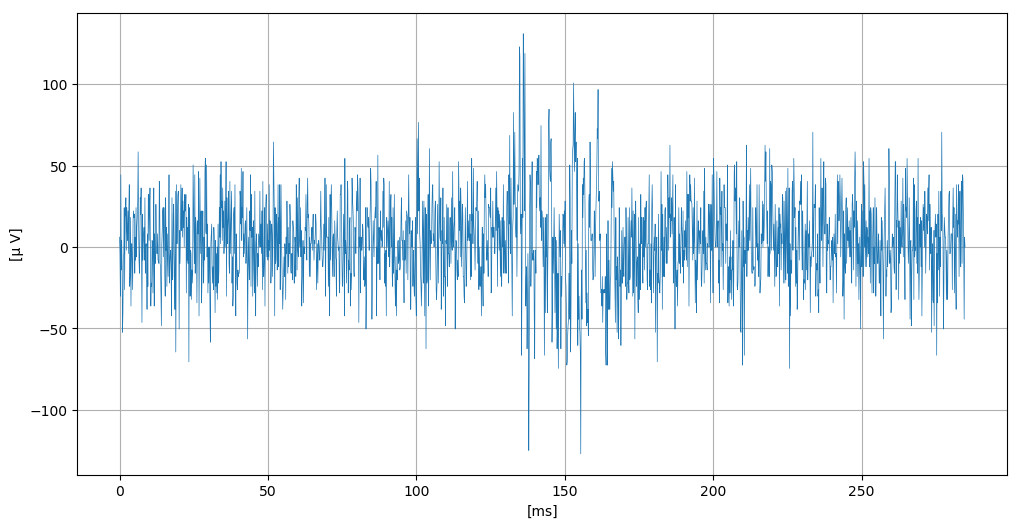

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f77f2398710>

In [21]:
figura=figure(figsize=(12,6))
grid()
#xlim(120,170)
xlabel("[ms]")
ylabel("[μ V]")
plot(rangotiempos, ejemplolfp, lw=0.5)

In [24]:
plan=plan_fft(ejemplolfp,  flags=FFTW.PATIENT)
fttotal=(plan*ejemplolfp);
ftsym=circshift(fttotal, div(nmax,2));

In [25]:
div(102,2)

51

In [26]:
epoder=map(abs2, ftsym);

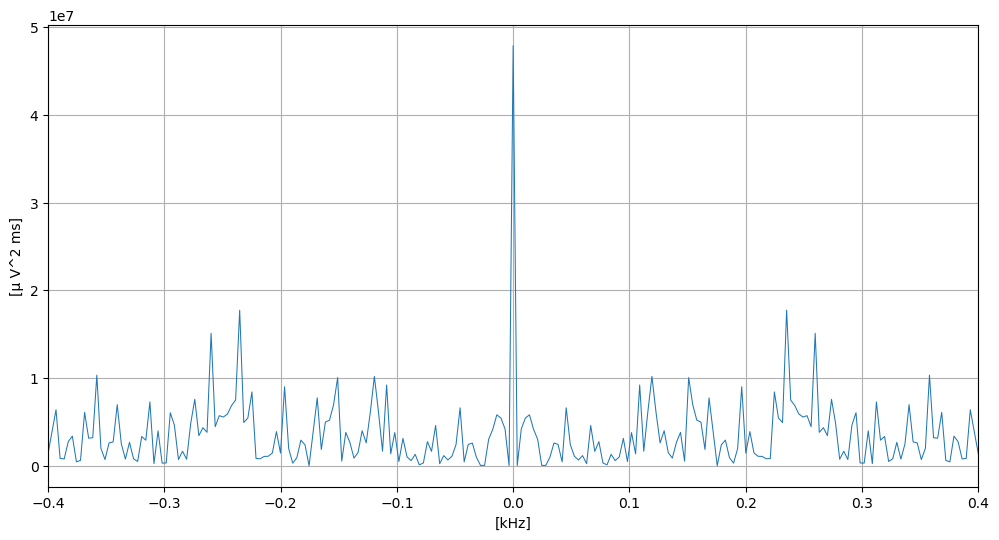

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f77f23e84a8>

In [27]:
figura=figure(figsize=(12,6))
grid(which="both")
xlim(-0.4,0.4)
xlabel("[kHz]")
ylabel("[μ V^2 ms]")
#yscale("log")
mediorango=1:500
plot(rfreqsim,epoder, lw=0.74)
#plot(rangofreqs[mediorango],epoder2[mediorango])

In [28]:
rangofreqs.step

Base.TwicePrecision{Float64}(0.003509274462041692, 0.0)

In [58]:
rara2=filtrobanda(rangofreqs, fttotal, 0.0035,0.007022);  #esto seria la banda theta

In [59]:
dot(rara2,rara2)

44523.490356676695 + 0.0im

Muy bien, hasta ahí parece funcionar. Hay que checar que esto también jale con indices pares. Ahora aplicamos a esto a los datos completos.

In [35]:
ffTotalTotal=zeros(Complex, 64, 64, nmax);
for j=1:64, k=1:64
    ffTotalTotal[j,k,:]=plan*vec(lfp[j,k,:])
end

In [36]:
# = funciones auxiliares para bandas "ineteresantes =#
fbajas(datos)=filtrobanda(rangofreqs,datos, 0.010, 0.060)
fmedias(datos)=filtrobanda(rangofreqs, datos, 0.1, 0.2)
faltas(datos)=filtrobanda(rangofreqs, datos, 0.2, 0.3)
faltotas(datos)=filtrobanda(rangofreqs, datos, 0.3, 0.45)

faltotas (generic function with 1 method)

In [60]:
fdelta(datos)=filtrobanda(rangofreqs,datos, 0.0001, 0.0035)
ftheta(datos)=filtrobanda(rangofreqs, datos, 0.0035, 0.007022)
falpha(datos)=filtrobanda(rangofreqs, datos, 0.007022, 0.014044)
fbeta(datos)=filtrobanda(rangofreqs, datos, 0.014044, 0.035120)
fgamma(datos)=filtrobanda(rangofreqs, datos, 0.035120, 0.100)
fspr(datos)=filtrobanda(rangofreqs, datos, 0.100, 0.250)
fuspr(datos)=filtrobanda(rangofreqs, datos, 0.250, 0.600)

fuspr (generic function with 1 method)

Las unidades son un relajo. Tenemos que $V^2 \cdot s$ ( Volts cuadrados por segundos ) son Joules entre Coulombs. La transformada de Fourier esta en $ V \cdot s$, Volts segundos. Al cuadrar y multiplicar por $ d \omega$,nos da otra vez $ V^2 s$ que esta bien. Pero nuestra señal esta en $mV \cdot ms$. Eso da que la Transformada de Fourier está en $10^{-6} Vs$. Al cuadrar queda en $10^{-12}$, y nuestra $d \omega$ esta en kHz. Por ende el resultado de la integral esta en $10^{-9} J/C$.

In [61]:
factor=10^9
poderbajo=zeros(Real, 64,64)
podermedio=zeros(Real, 64,64)
poderalto=zeros(Real, 64,64)
poderaltote=zeros(Real, 64,64)
for j=1:64, k=1:64
    aux=fbajas(ffTotalTotal[j,k,:])
    poderbajo[j,k]=convert(Real, dot(aux,aux))/factor
    aux=fmedias(ffTotalTotal[j,k,:])
    podermedio[j,k]=convert(Real, dot(aux,aux))/factor
    aux=faltas(ffTotalTotal[j,k,:])
    poderalto[j,k]=convert(Real, dot(aux,aux))/factor
    aux=faltotas(ffTotalTotal[j,k,:])
    poderaltote[j,k]=convert(Real, dot(aux,aux))/factor
end

In [64]:
poderdelta=zeros(Real,64,64)
podertheta=zeros(Real,64,64)
poderalpha=zeros(Real,64,64)
poderbeta=zeros(Real,64,64)
podergamma=zeros(Real,64,64)
poderspr=zeros(Real,64,64)
poderuspr=zeros(Real,64,64);

In [65]:
listapoder=(poderdelta,podertheta, poderalpha,poderbeta,podergamma,poderspr,poderuspr)
listaf=(fdelta, ftheta, falpha, fbeta, fgamma, fspr, fuspr)

(fdelta, ftheta, falpha, fbeta, fgamma, fspr, fuspr)

In [76]:
ll=zip(listapoder, listaf)
for (p,f) in ll
    for j=1:64, k=1:64
    aux=f(ffTotalTotal[j,k,:])
    p[j,k]=convert(Real, dot(aux,aux))/factor
    end
end

In [78]:
extrema(podergamma)

(0.008265672584452275, 459.88107224100554)

In [79]:
saturados

17×2 Array{Int64,2}:
 59   8
 62  15
 34   4
 45  29
 61  15
 62  24
 52  12
  2   9
 64  32
 47  62
 60   2
  1   1
 40  60
 53   3
 36  28
  1   8
 55   3

In [80]:
satux=saturados[:,2]
satuy=saturados[:,1]
bonsx=buenos[:,2]
bonsy=buenos[:,1];

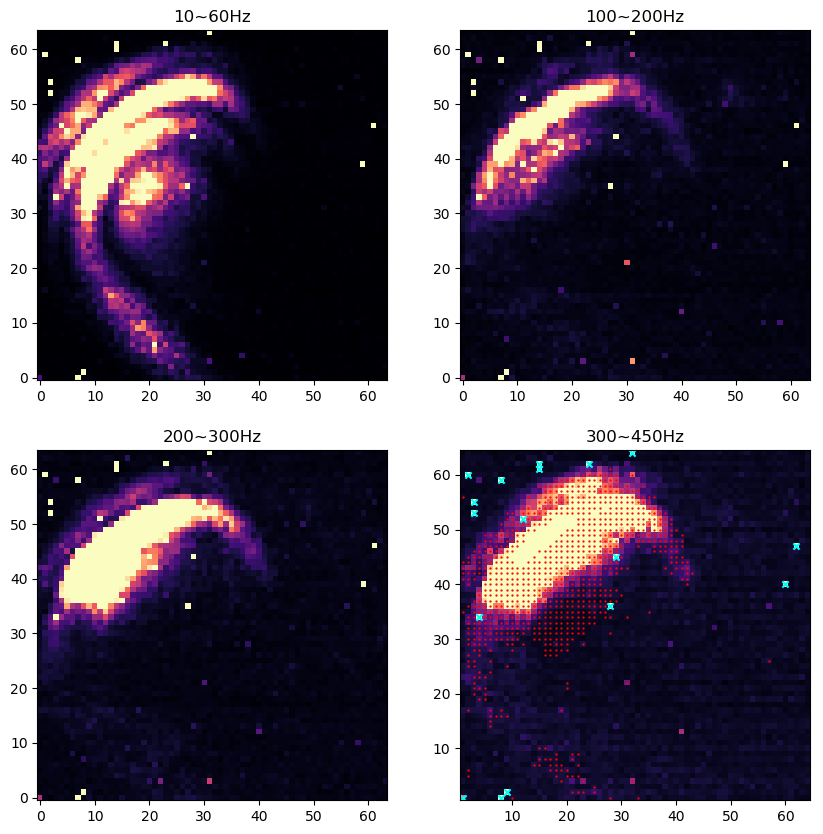

In [91]:
farofa, lista =subplots(2,2, figsize=(10,10))

(pmin, pmax)= (0, 2)

exten=[0.5,64.5,0.5,64.5]

lista[1,1][:imshow](poderbajo, vmin=pmin, vmax=pmax, origin="lower", cmap="magma")
lista[1,1][:title][:set_text]("10~60Hz")

lista[1,2][:imshow](podermedio, vmin=pmin, vmax=pmax, origin="lower", cmap="magma")
lista[1,2][:title][:set_text]("100~200Hz")

lista[2,1][:imshow](poderalto, vmin=pmin, vmax=pmax, origin="lower", cmap="magma")
lista[2,1][:title][:set_text]("200~300Hz")

lista[2,2][:imshow](poderaltote, vmin=pmin, vmax=pmax, origin="lower", cmap="magma", extent=exten)
lista[2,2][:title][:set_text]("300~450Hz")

scatter(bonsx, bonsy, marker="o", c="red", s=0.4)
scatter(satux, satuy, marker="x", c="cyan", s=20)


#farofa[:colorbar](lista[2,2], ax=lista, orientation="horizontal", fraction=.1)

savefig("EspectrosdePoderporBandasArbitrarias.png", dpi=90)

#colorbar()

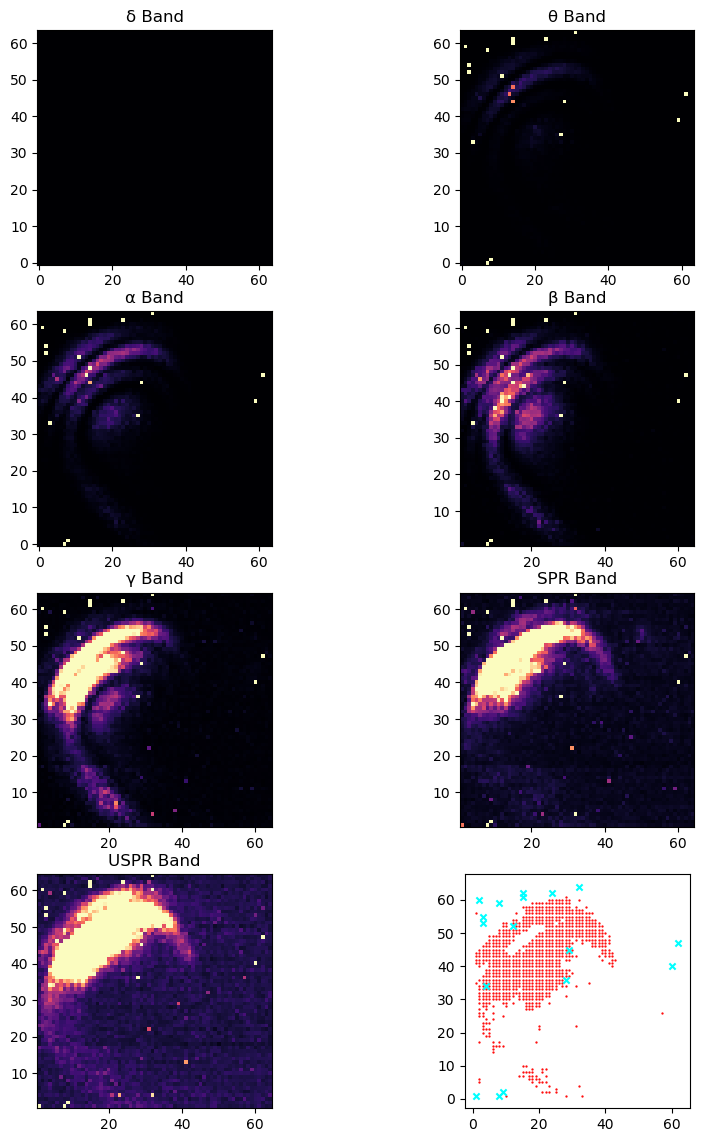

In [90]:
farofa, lista =subplots(4,2, figsize=(10,14))

(pmin, pmax)= (0, 2)

exten=[0.5,64.5,0.5,64.5]

lista[1,1][:imshow](poderdelta, vmin=pmin, vmax=pmax, origin="lower", cmap="magma")
lista[1,1][:title][:set_text]("δ Band")

lista[1,2][:imshow](podertheta, vmin=pmin, vmax=pmax, origin="lower", cmap="magma")
lista[1,2][:title][:set_text]("θ Band")

lista[2,1][:imshow](poderalpha, vmin=pmin, vmax=pmax, origin="lower", cmap="magma")
lista[2,1][:title][:set_text]("α Band")

lista[2,2][:imshow](poderbeta, vmin=pmin, vmax=pmax, origin="lower", cmap="magma", extent=exten)
lista[2,2][:title][:set_text]("β Band")

lista[3,1][:imshow](podergamma, vmin=pmin, vmax=pmax, origin="lower", cmap="magma", extent=exten)
lista[3,1][:title][:set_text]("γ Band")

lista[3,2][:imshow](poderspr, vmin=pmin, vmax=pmax, origin="lower", cmap="magma", extent=exten)
lista[3,2][:title][:set_text]("SPR Band")

lista[4,1][:imshow](poderuspr, vmin=pmin, vmax=pmax, origin="lower", cmap="magma", extent=exten)
lista[4,1][:title][:set_text]("USPR Band")

lista[4,2][:set_aspect]("equal")
lista[4,2][:scatter](bonsx, bonsy, marker="o", c="red", s=0.4)
lista[4,2][:scatter](satux, satuy, marker="x", c="cyan", s=20)


#farofa[:colorbar](lista[2,2], ax=lista, orientation="horizontal", fraction=.1)

savefig("EspectrosdePoderporBandasTradicionales.png", dpi=90)

#colorbar()

In [92]:
skt=wfft(ejemplolfp, 350);
ranguitof=(0:349).*(freq/350)

0.0:0.0200630234244155:7.001995175121009

In [93]:
epoder=map(abs2, skt)./factor;

In [94]:
extrema(epoder), size(epoder)

((0.0, 0.009504667091541288), (1651, 350))

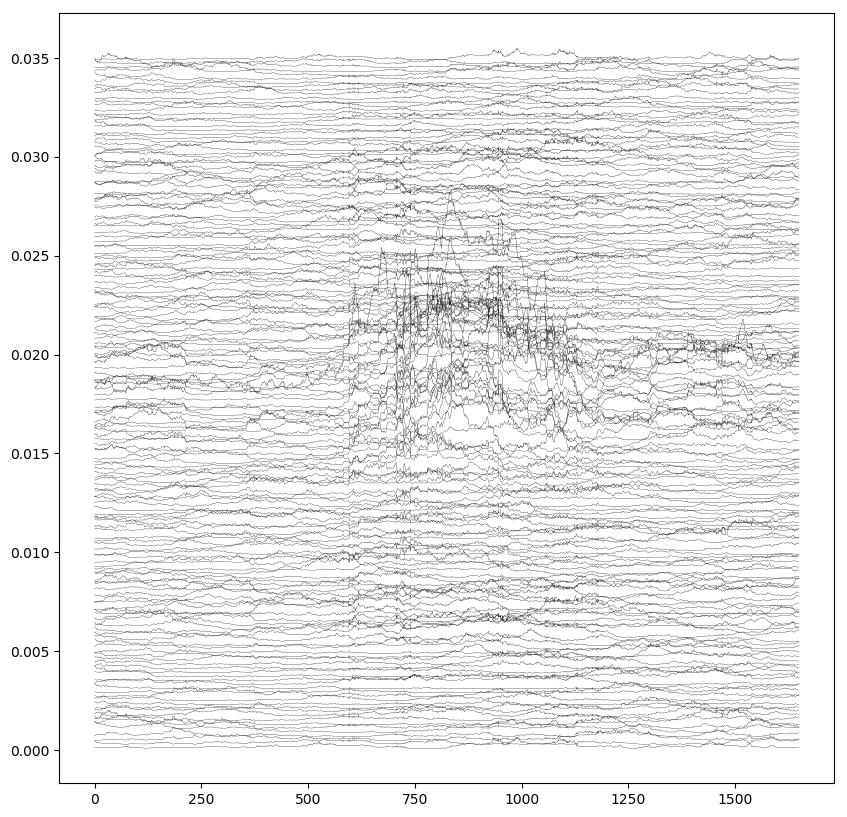

In [121]:
f=figure(figsize=(10,10))
#xlim(0,2)
#axis("off")

fmax=size(epoder)[2]
datossym=circshift(epoder, (0,div(fmax,2)))

for j=1:2:(350)
    datos=vec(datossym[:,j+1]).+(j*0.0001)
    plot(datos, lw=0.2, c="black")
end

#savefig("texturadefrequenciasa01.png", dpi=90)


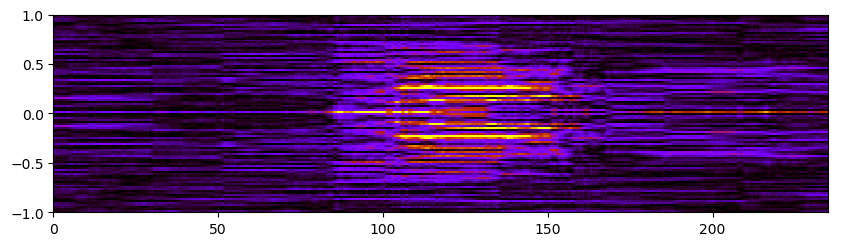

PyObject <matplotlib.image.AxesImage object at 0x7f77f0f5bba8>

In [153]:
f=figure(figsize=(10,10))

(twmax , fwmax)= size(datossym)

twmax=twmax/freq
fwmax=freq

(pmin,pmax)=extrema(datossym)

ylim(-1,1)

extento=[0,twmax,-fwmax/2,fwmax/2]

bla=permutedims(datossym, [2,1])

imshow(bla, origin="lower", cmap="gnuplot", extent=extento, aspect=30, vmin=pmin, vmax=0.5*pmax)

In [158]:

(cmax, smax)=size(skt)

poderwindowgamma=zeros(cmax)
poderwindowalpha=zeros(cmax)
poderwindowbeta=zeros(cmax)
poderwindowspr=zeros(cmax)


for j=1:cmax
    aux=fgamma(skt[j,:])
    poderwindowgamma[j]=dot(aux, aux)
    
    aux=falpha(skt[j,:])
    poderwindowalpha[j]=dot(aux, aux)

    aux=fbeta(skt[j,:])
    poderwindowbeta[j]=dot(aux, aux)

    aux=fspr(skt[j,:])
    poderwindowspr[j]=dot(aux, aux)
    
end


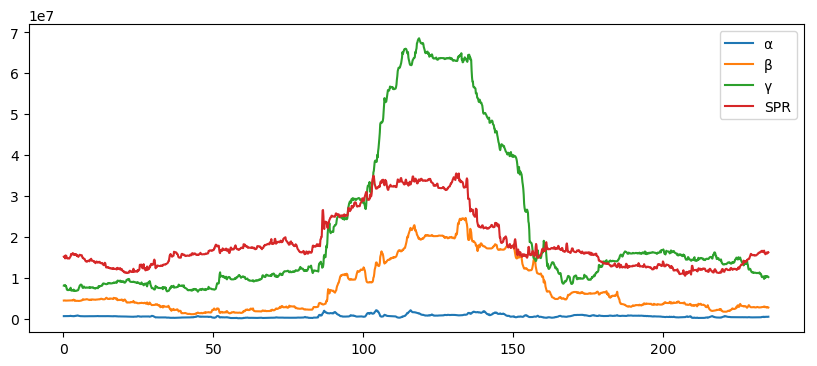

PyObject <matplotlib.legend.Legend object at 0x7f77f0c3f908>

In [168]:
figura=figure(figsize=(10,4))
trange=(1:cmax)./freq

plot(trange,poderwindowalpha, label="α")
plot(trange,poderwindowbeta, label="β")
plot(trange,poderwindowgamma, label="γ")
plot(trange,poderwindowspr, label="SPR")

legend()


In [178]:
podergammaventana=zeros(64,64,cmax)

cvent=350
cmax=nmax-cvent
podergammaventana=zeros(64,64,cmax)


@time for j=1:4, k=1:4
   wtaux=wfft(lfp[j,k,:], cvent)
   for t=1:cmax
        auxfilt=fgamma(wtaux[t,:])
        podergammaventana[j,k,t]=dot(auxfilt,auxfilt)
    end
    
end


 17.704446 seconds (64.27 M allocations: 2.764 GiB, 47.13% gc time)


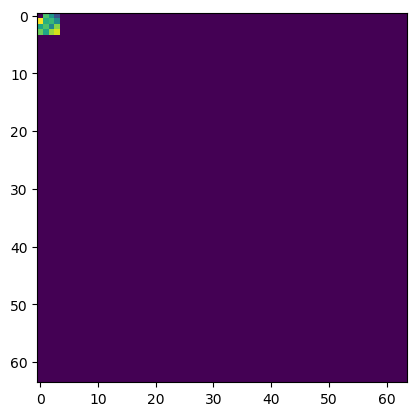

PyObject <matplotlib.image.AxesImage object at 0x7f77f18d6ac8>

In [180]:
imshow(podergammaventana[:,:,100])

In [96]:
a,b=size(epoder)
xx=collect(1:a)
yy=collect(1:b);

xxs=repeat(xx,outer=(1,b))
yys=permutedims(repeat(yy, outer=(1,a)))

xxs=xxs./freq
yys=yys.*(freq/350)

#plot_wireframe(xxs, yys, epoder)

1651×350 Array{Float64,2}:
 0.020063  0.040126  0.0601891  …  6.96187  6.98193  7.002  7.02206
 0.020063  0.040126  0.0601891     6.96187  6.98193  7.002  7.02206
 0.020063  0.040126  0.0601891     6.96187  6.98193  7.002  7.02206
 0.020063  0.040126  0.0601891     6.96187  6.98193  7.002  7.02206
 0.020063  0.040126  0.0601891     6.96187  6.98193  7.002  7.02206
 0.020063  0.040126  0.0601891  …  6.96187  6.98193  7.002  7.02206
 0.020063  0.040126  0.0601891     6.96187  6.98193  7.002  7.02206
 0.020063  0.040126  0.0601891     6.96187  6.98193  7.002  7.02206
 0.020063  0.040126  0.0601891     6.96187  6.98193  7.002  7.02206
 0.020063  0.040126  0.0601891     6.96187  6.98193  7.002  7.02206
 0.020063  0.040126  0.0601891  …  6.96187  6.98193  7.002  7.02206
 0.020063  0.040126  0.0601891     6.96187  6.98193  7.002  7.02206
 0.020063  0.040126  0.0601891     6.96187  6.98193  7.002  7.02206
 ⋮                              ⋱                                  
 0.020063  0.040126  

In [97]:
xxs

1651×350 Array{Float64,2}:
   0.142408    0.142408    0.142408  …    0.142408    0.142408    0.142408
   0.284817    0.284817    0.284817       0.284817    0.284817    0.284817
   0.427225    0.427225    0.427225       0.427225    0.427225    0.427225
   0.569634    0.569634    0.569634       0.569634    0.569634    0.569634
   0.712042    0.712042    0.712042       0.712042    0.712042    0.712042
   0.85445     0.85445     0.85445   …    0.85445     0.85445     0.85445 
   0.996859    0.996859    0.996859       0.996859    0.996859    0.996859
   1.13927     1.13927     1.13927        1.13927     1.13927     1.13927 
   1.28168     1.28168     1.28168        1.28168     1.28168     1.28168 
   1.42408     1.42408     1.42408        1.42408     1.42408     1.42408 
   1.56649     1.56649     1.56649   …    1.56649     1.56649     1.56649 
   1.7089      1.7089      1.7089         1.7089      1.7089      1.7089  
   1.85131     1.85131     1.85131        1.85131     1.85131     1.85131

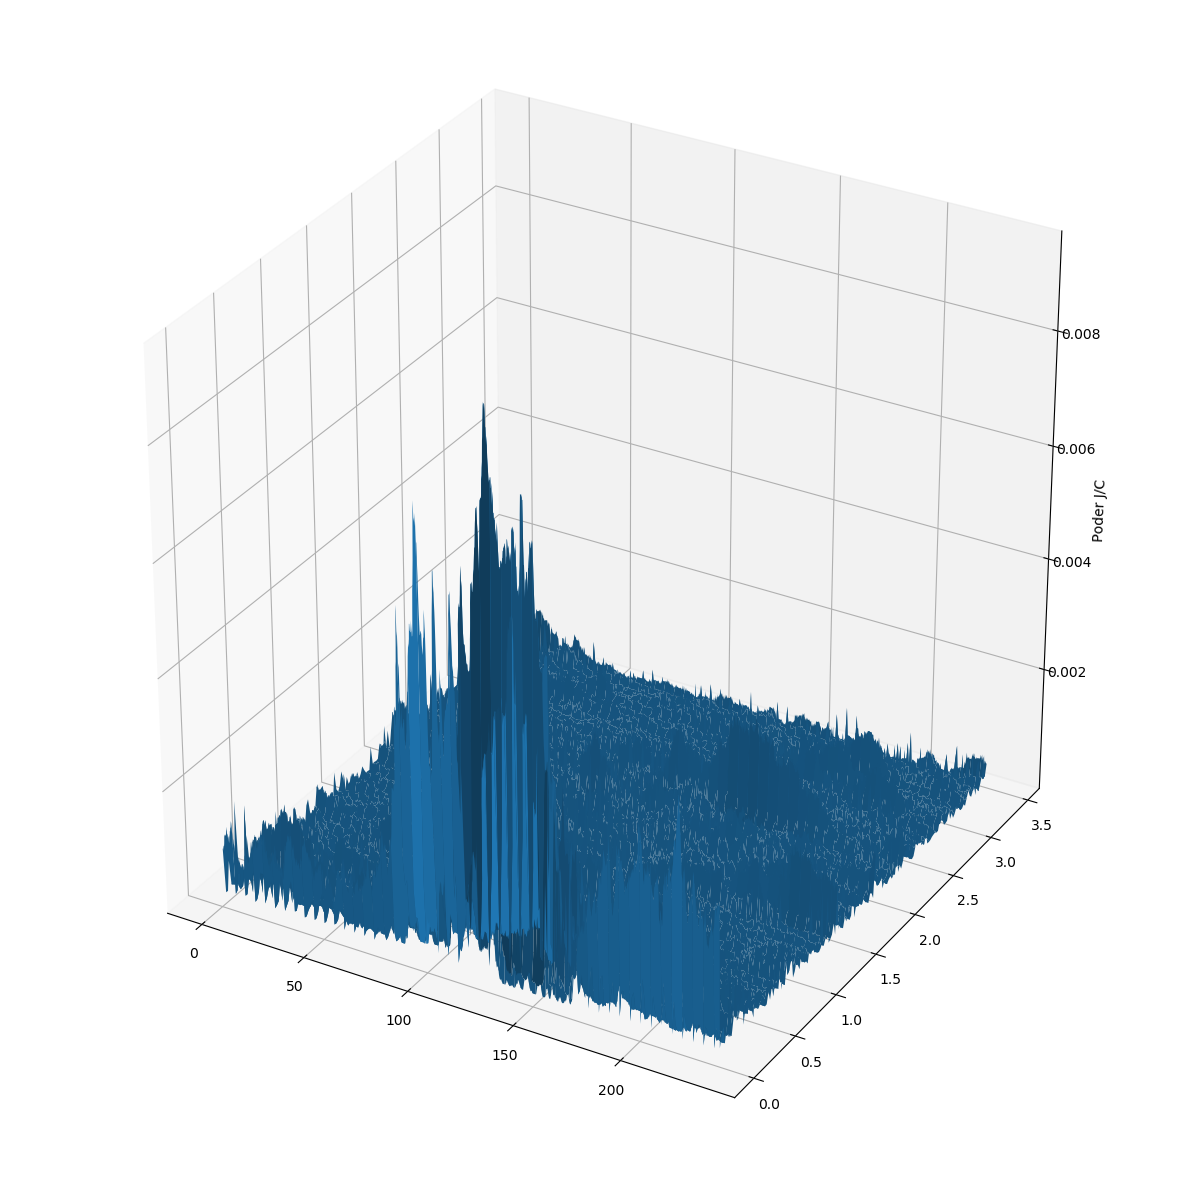

PyObject <mpl_toolkits.mplot3d.art3d.Poly3DCollection object at 0x7f77f12c6da0>

In [98]:
f=figure(figsize=(15,15))
ylim(0,3.5)
xlabel("Tiempo ms")
ylabel("frequencia kHz")
zlabel("Poder J/C")
plot_surface(xxs[:,1:170], yys[:,1:170], epoder[:,1:170], lw=0.5)

In [99]:
?view

search: view @view @views DivideError vlines axvline evalfile readavailable



```
view(A, inds...)
```

Like [`getindex`](@ref), but returns a view into the parent array `A` with the given indices instead of making a copy.  Calling [`getindex`](@ref) or [`setindex!`](@ref) on the returned `SubArray` computes the indices to the parent array on the fly without checking bounds.

# Examples

```jldoctest
julia> A = [1 2; 3 4]
2×2 Array{Int64,2}:
 1  2
 3  4

julia> b = view(A, :, 1)
2-element view(::Array{Int64,2}, :, 1) with eltype Int64:
 1
 3

julia> fill!(b, 0)
2-element view(::Array{Int64,2}, :, 1) with eltype Int64:
 0
 0

julia> A # Note A has changed even though we modified b
2×2 Array{Int64,2}:
 0  2
 0  4
```


In [100]:
figura=figure(figsize=(13,10))
grid()
#xlim(120,170)
xlabel("[ms]")
ylabel("[μ V]")
#plot(rangotiempos, signalfiltrad, lw=1.5)
plot(rangotiempos, signalfiltrad2, lw=1.5)
#plot(rangotiempos, signalfiltrad+signalfiltrad2, lw=1.65)
plot(rangotiempos, ejemplolfp, lw=0.3)


UndefVarError: UndefVarError: signalfiltrad2 not defined

In [101]:
a=0.053022
tol=2*step(rangofreqs)
q(x)=isapprox(a,x, atol=tol)
findfirst(q, rangofreqs)


15

In [ ]:
rangofreqs[12:17]

In [ ]:
map(q, rangofreqs[12:17])

In [ ]:
collect(rangofreqs[12:17])

In [ ]:
step(rangofreqs)

In [ ]:
a=0.005
p=indicecercano(a, rangofreqs)

In [ ]:
rangofreqs[2]

In [ ]:
rangofreqs[57]

In [ ]:
figura=figure(figsize=(12,6))
grid()
xlabel("[kHz]")
ylabel("[μ V^2]")
plot(subfreqs,epoder2)